### Lab-3 : Self-Practice

#### In this week, your self-practice task will consist to analyze the impact of class imballance on the performance of the logistic regression model.

#### Class imbalance is very common in real life. For example, in a classification problem to predict whether a person has a certain very rare disease, the dataset will always contain more negative samples than positive ones. This situation can have a significant impact on the performance of the model. You will analyze this situation in the case of the Titanic dataset used in the lab.

### 1. Load the titanic dataset and <b>PLOT</b> the proportion of positive and negative samples (survived vs non survived)

In [1]:
import os
import pandas as pd
data_loc = os.path.join('titanic.csv')
df = pd.read_csv(data_loc).rename(columns={"survived":"y"})
print(df.head())

   y  pclass                                             name     sex    age  \
0  1       1                    Allen, Miss. Elisabeth Walton  female  29.00   
1  1       1                   Allison, Master. Hudson Trevor    male   0.92   
2  0       1                     Allison, Miss. Helen Loraine  female   2.00   
3  0       1             Allison, Mr. Hudson Joshua Creighton    male  30.00   
4  0       1  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female  25.00   

   sibsp  parch      fare embarked  
0      0      0  211.3375        S  
1      1      2  151.5500        S  
2      1      2  151.5500        S  
3      1      2  151.5500        S  
4      1      2  151.5500        S  


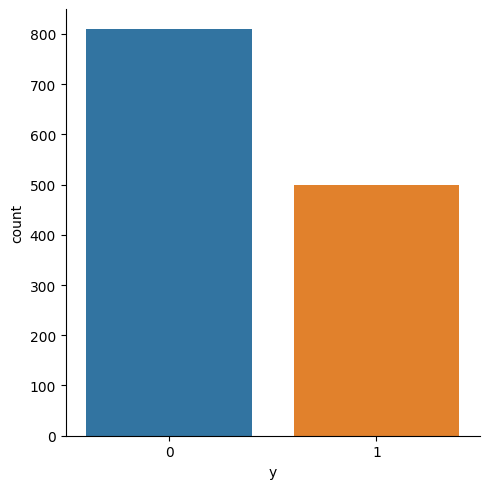

In [2]:
### write your code here. Load the dataset and plot (barplot) proportion of each class
import seaborn as sns
import matplotlib.pyplot as plt
sns.catplot(kind='count', x='y', data=df)
plt.show()
# we can see that the number of positively classified examples is arund 500 while negatively classified ones are around 800.

#### Preprocess the data as it has been done in the lab, feel free to adapt

In [3]:
import re
# let's rename some columns
df = df.rename(columns={"pclass": "c", "embarked": "from"})
print(df.columns)

# let's engineer the title feature:
df['title'] = df['name'].apply(lambda x: re.sub('[:?;.]', ",", x).split(",")[1].strip())
print(df['title'].value_counts())

Index(['y', 'c', 'name', 'sex', 'age', 'sibsp', 'parch', 'fare', 'from'], dtype='object')
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Ms                2
Major             2
Capt              1
Sir               1
Dona              1
Jonkheer          1
the Countess      1
Don               1
Mme               1
Lady              1
Name: title, dtype: int64


In [4]:
import numpy as np
# we can see that the age in class 1 and 2 has low variance as low number of unique values, meaning mean or median statics are good enough
# to fill up the missing values in these two groups
age_class = df.groupby('c').agg({"age":[np.mean, np.median]}).iloc[:, 0]
# this table aggregates the age in the 3rd class by title. Some minor research reveals that title is highly correlated with the 
# marital status and consequently with age. 
# As most of the age missing values are within the 3rd class, more careful imputing should be conducted.
# each missing value will be replaced with the average of the mean of 3rd class passengers with the same title
title_age_class_3 = df[df['c'] == 3].groupby('title').agg({"age":np.nanmean}).iloc[:, 0]


def fill_age_class_3(row):
    value1 = np.round(title_age_class_3[row['title']])
    value2 = np.round(age_class[row['c']]) # used only for one passenger with title Ms.
    if np.isnan(row['age']):
        row['age'] =  value2 if np.isnan(value1) else value1
    return row

def fill_age_class_1_2(row):
    if np.isnan(row['age']):
        row['age'] = np.round(age_class[row['c']])
    return row

def fill_age(row):
    if row['c'] == 3:
        return fill_age_class_3(row)
    return fill_age_class_1_2(row)

# fill the age
df = df.apply(fill_age, axis=1)

# drop the title as it no longer needed
df.drop('title', axis=1, inplace=True)

def fam(row):
    row['fam'] = row['sibsp'] + row['parch']
    return row

df = df.apply(fam, axis=1)

# drop sibsp and parch columns
for col in ['sibsp', 'parch', 'name']:
    df.drop(col, axis=1, inplace=True)

print(df.columns)


Index(['y', 'c', 'sex', 'age', 'fare', 'from', 'fam'], dtype='object')


In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
# drop two nan columns
print(df.isna().sum())
df.dropna(subset=['fare', 'from'], inplace=True)
print(df.isna().sum())

# encode categorical features
def ohe_new_features(df, features_name, encoder):
    new_feats = encoder.transform(df[features_name])
    # create dataframe from encoded features with named columns
    new_cols = pd.DataFrame(new_feats, dtype=int, columns=encoder.get_feature_names(features_name))
    new_df = pd.concat([df, new_cols], axis=1)    
    new_df.drop(features_name, axis=1, inplace=True)
    return new_df

encoder = OneHotEncoder(sparse=False, drop='first')
f_names = ['sex', 'from']
encoder.fit(df[f_names])

df = ohe_new_features(df, f_names, encoder)

scaler = MinMaxScaler()
scaler.fit(df)
df = pd.DataFrame(scaler.transform(df), columns=df.columns)
print(df.head())

y       0
c       0
sex     0
age     0
fare    1
from    2
fam     0
dtype: int64
y       0
c       0
sex     0
age     0
fare    0
from    0
fam     0
dtype: int64
     y    c       age      fare  fam  sex_male  from_Q  from_S
0  1.0  0.0  0.361142  0.412503  0.0       0.0     0.0     1.0
1  1.0  0.0  0.009395  0.295806  0.3       1.0     0.0     1.0
2  0.0  0.0  0.022924  0.295806  0.3       0.0     0.0     1.0
3  0.0  0.0  0.373669  0.295806  0.3       1.0     0.0     1.0
4  0.0  0.0  0.311036  0.295806  0.3       0.0     0.0     1.0


/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [6]:
df.head()

,y,c,age,fare,fam,sex_male,from_Q,from_S
0,1.0,0.0,0.361142,0.412503,0.0,0.0,0.0,1.0
1,1.0,0.0,0.009395,0.295806,0.3,1.0,0.0,1.0
2,0.0,0.0,0.022924,0.295806,0.3,0.0,0.0,1.0
3,0.0,0.0,0.373669,0.295806,0.3,1.0,0.0,1.0
4,0.0,0.0,0.311036,0.295806,0.3,0.0,0.0,1.0


## 2. Impact of class imbalance. 
##### Now, you will `artificially` imbalance the dataset. From the original dataset, create different dataset with the following class representations (drop samples from one class): 
##### 1. 20% vs 80%
##### 2. 30% vs 70%
##### 3. 40% vs 60%

## Split each data into train and test set as in the lab; train logistic regression model for each setting and report (PLOT) the accuracy, precision, and recall of each model

In [7]:
from math import ceil

### write your code here 
def imbalance_data(df, p1, p2, y='y', classes=None):
    if classes is None:
        classes = [0, 1]
    assert p1 + p2 == 1
    df = df.copy()

    max_p = max(p1, p2)
    min_p = min(p1, p2)

    n1 = len(df[df[y] == classes[0]])
    n2 = len(df[df[y] == classes[1]])
    
    max_n = max(n1, n2)
    min_n = min(n1, n2) 
    
    min_cls = classes[0] if min_n == n1 else classes[1] # min class
    max_cls = classes[1] if min_cls == classes[0] else classes[0]
    
    if max_n >= min_n * max_p / min_p:
        # remove from the classes with the largest number of examples
        new_value = ceil(min_n * max_p / min_p)
        remove_number = max_n - new_value
        remove = max_cls
    
    elif min_n >= max_n * min_p / max_p:
        # remove from the classes with the smallest number of examples
        new_value = ceil(max_n * min_p / max_p)
        remove_number = min_n - new_value
        remove = min_cls
    else:
        print("SORRY THE NEW DISTRIBUTION IS NOT ACHIEVABLE!!!")
        return         
    
    removed = 0
    for i in range(len(df)):
        if removed == remove_number:
            break
        if df.loc[i, y] == remove:
            df.drop(i, axis=0, inplace=True)
            removed += 1
    
    return df.dropna()
    
def print_class_balance(df, y='y', classes=None):
    if classes is None:
        classes = [0, 1]
    n = len(df)
    n1 = len(df[df[y] == classes[0]])
    n2 = len(df[df[y] == classes[1]])
    print(f"Percentage of example belonging to class {str(classes[0])} is: {str(n1 / n)}")
    print(f"Percentage of example belonging to class {str(classes[1])} is: {str(n2 / n)}")   
    
df_20_80 = imbalance_data(df, 0.2, 0.8)
df_30_70 = imbalance_data(df, 0.3, 0.7)
df_40_60 = imbalance_data(df, 0.4, 0.6)

dfs = [df_20_80, df_30_70, df_40_60]
for d in dfs:
    print_class_balance(d)
    print("#" * 50)


Percentage of example belonging to class 0 is: 0.7986111111111112
Percentage of example belonging to class 1 is: 0.2013888888888889
##################################################
Percentage of example belonging to class 0 is: 0.6987847222222222
Percentage of example belonging to class 1 is: 0.3012152777777778
##################################################
Percentage of example belonging to class 0 is: 0.5990338164251208
Percentage of example belonging to class 1 is: 0.40096618357487923
##################################################


In [8]:
# # set the parameters
# lambdas = np.array([10 ** i for i in range(-4, 2)])
# Cs = 1 / lambdas    
# params =  {"C": Cs}
# # set the Cross validatition
# CV = StratifiedKFold(n_splits=4, shuffle=True, random_state=11)
# log_reg_searcher = GridSearchCV(log_reg, params, cv=)
# log_reg_searcher.fit(X_train, y_train)

In [9]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def train_logistic_reg(df, y='y', test_size=0.2):
    Y = df[y].copy()
    df = df.drop(y, axis=1)
    # split the data into train and test sets while conserving the initial distribution of the classes
    X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size=test_size, random_state=11, stratify=Y)
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    
    print("PERCENTAGE OF PREDICTIONS BELONGING TO EACH CLASS")
    print_class_balance(pd.DataFrame(data=y_pred, columns=['y']))
    print()
    print("METRICS")
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    print(f"recall: {str(rec)}")
    print(f"precision: {str(prec)}")
    print(f"f_1 score: {str(f1)}")
    print(f"accuracy: {str(acc)}")
    print()
    data = [log_reg, y_pred, X_train, X_test, y_train, y_test]
    metrics = [rec, prec, f1, acc]
    return data, metrics

log_regs = [train_logistic_reg(d) for d in dfs]

PERCENTAGE OF PREDICTIONS BELONGING TO EACH CLASS
Percentage of example belonging to class 0 is: 1.0
Percentage of example belonging to class 1 is: 0.0

METRICS
recall: 0.0
precision: 0.0
f_1 score: 0.0
accuracy: 0.7970297029702971

PERCENTAGE OF PREDICTIONS BELONGING TO EACH CLASS
Percentage of example belonging to class 0 is: 0.961038961038961
Percentage of example belonging to class 1 is: 0.03896103896103896

METRICS
recall: 0.07142857142857142
precision: 0.5555555555555556
f_1 score: 0.12658227848101264
accuracy: 0.7012987012987013

PERCENTAGE OF PREDICTIONS BELONGING TO EACH CLASS
Percentage of example belonging to class 0 is: 0.6546184738955824
Percentage of example belonging to class 1 is: 0.3453815261044177

METRICS
recall: 0.56
precision: 0.6511627906976745
f_1 score: 0.6021505376344087
accuracy: 0.7028112449799196



/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


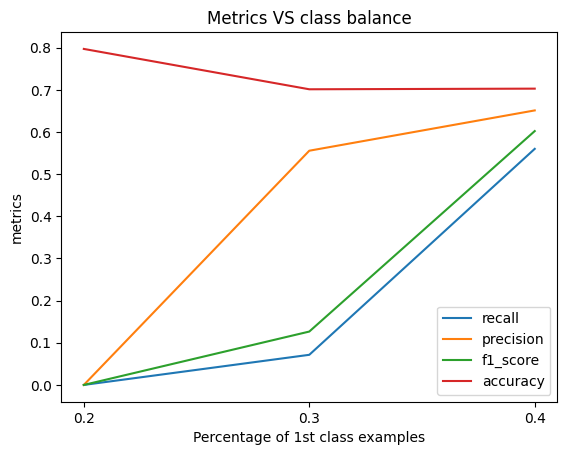

In [10]:
## let's plot the results
class_1_perc = [0.2, 0.3, 0.4]
recalls = [log_reg[1][0] for log_reg in log_regs]
precisions = [log_reg[1][1] for log_reg in log_regs]
f1_s = [log_reg[1][2] for log_reg in log_regs]
accuracies = [log_reg[1][3] for log_reg in log_regs]


plt.plot(class_1_perc, recalls, label='recall')#, line_style='-')
plt.plot(class_1_perc, precisions, label='precision')#, line_style='**')
plt.plot(class_1_perc, f1_s, label='f1_score')#), line_style='--')
plt.plot(class_1_perc, accuracies, label='accuracy')#, line_style=':')
plt.title("Metrics VS class balance")
plt.xlabel("Percentage of 1st class examples")
plt.ylabel("metrics")
plt.xticks([0.2, 0.3, 0.4])
plt.legend()
plt.show()


## 3. Analyse the class-wise accuracy. 
#### For each model, plot (bar plots) the class-wise accuracy, i.e., the accuracy for each class.

THE accuracy for class 0 is 1.0
THE accuracy for class 1 is 0.0


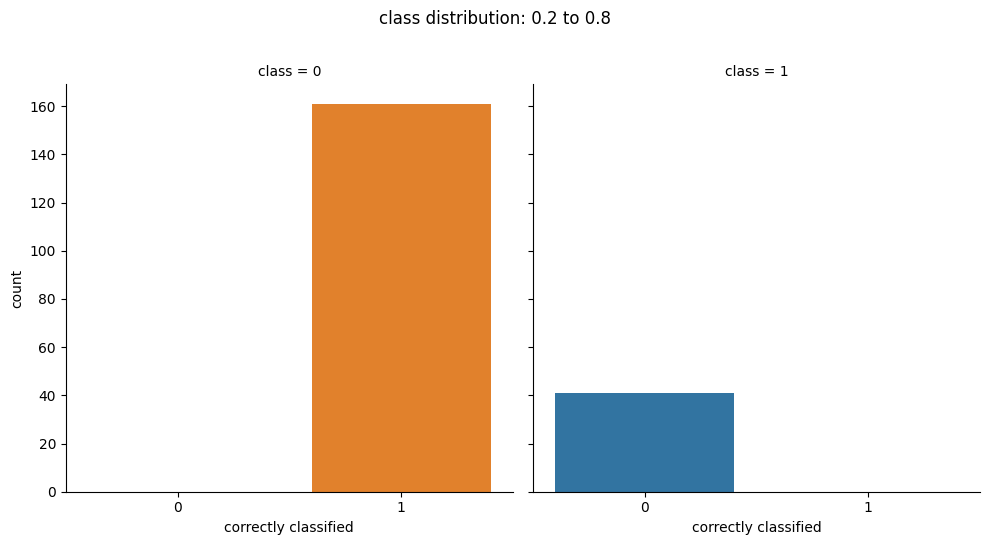


THE accuracy for class 0 is 0.9751552795031055
THE accuracy for class 1 is 0.07142857142857142


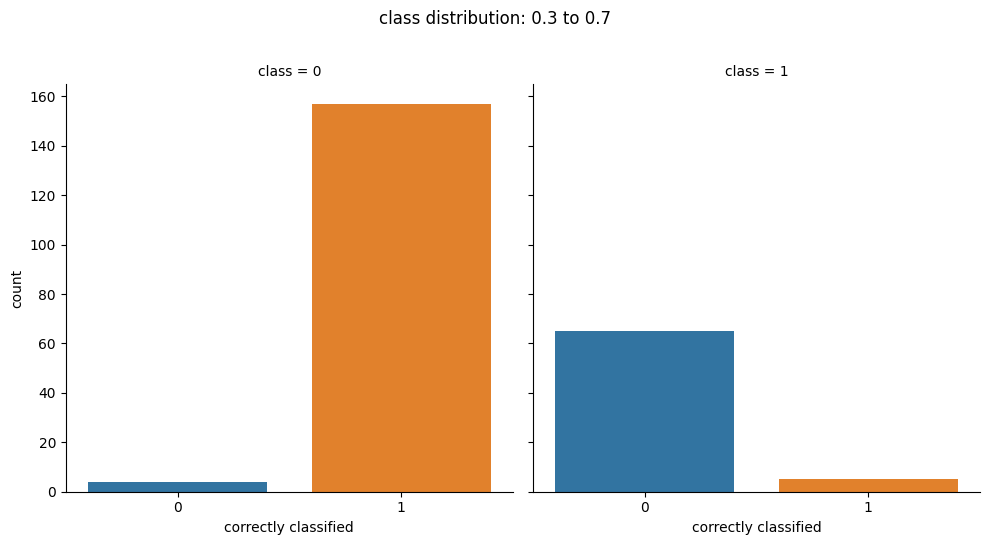


THE accuracy for class 0 is 0.7986577181208053
THE accuracy for class 1 is 0.56


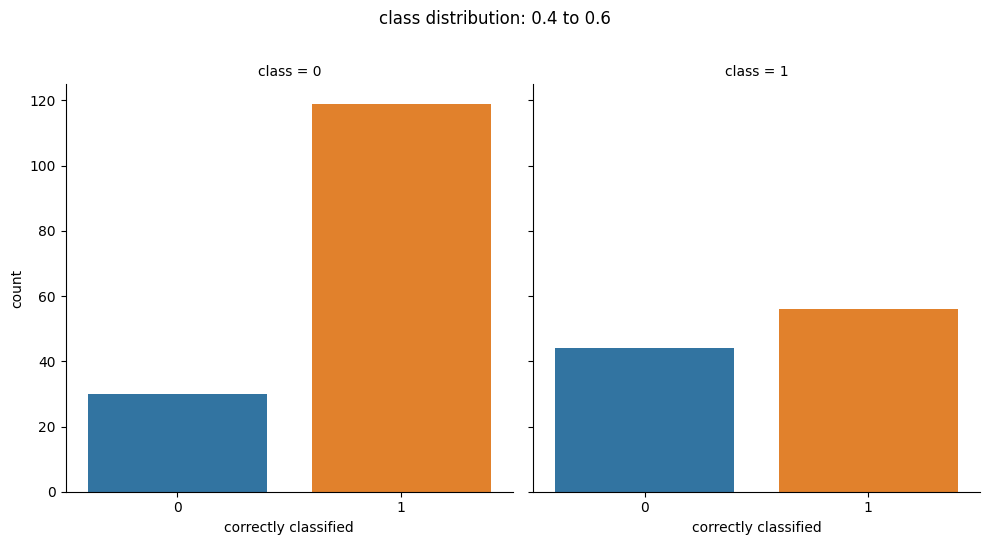

In [11]:
#### write your code 
def class_acc(log_reg, classes=None):
    if classes is None:
        classes = [0, 1]
    y_pred = log_reg[0][1]
    y_test = log_reg[0][-1]
    accs = [np.sum((y_pred == y_test)& (y_pred == c)) / np.sum((y_test == c)) for c in classes]
    for acc, c in list(zip(accs, classes)):
        print(f"THE accuracy for class {str(c)} is {str(acc)}")

def plot_accuracies(log_reg, percentage, classes=None):
    if classes is None:
        classes = [0, 1]
    y_pred = log_reg[0][1]
    y_test = log_reg[0][-1]
    data = np.concatenate([y_pred.reshape(-1, 1).astype(int), 
                           y_test.values.reshape(-1, 1).astype(int), (y_pred == y_test).values.astype(int).reshape(-1, 1)], axis=1)
    

    df = pd.DataFrame(data=data, columns=['pred', 'class', 'correct'])
    g = sns.catplot(kind='count', data=df, x='correct', col='class', col_order=[0, 1])
    g.fig.suptitle(f"class distribution: {str(percentage)} to {str(1 - percentage)}", y=1.08)
    g.set(xlabel='correctly classified', ylabel='count')
    plt.show()

for lg, p in zip(log_regs, [0.2, 0.3, 0.4]):
    class_acc(lg)
    plot_accuracies(lg, p)
    print()

## 4. Report 
### Write a small report (few sentences) to discuss from your analysis, the impact of class imballance on logistic model's performance 


From the analysis preformed above, it can be concluded that class imbalance is detrimental for Logistic Regession's performance. Due to its simplicity, the model with datasets heavily imbalanced would tend to act as a majority guessing. This claim is supported by the fact that the model predicted almost all examples as negative in both datasets with (80\% , 20\%) splits and (70\%, 30\%) splits. For these datasets, the accuracy was relatively high. However, it was actually (almost) equal to the percentage of the negative class in the training dataset which is also reflected in the remarkably low values for both precision and recall.

The last dataset is more balanced. The predictions are more diversified in comparison to previous datasets. The general accuracy is relatively the same in comparison to the one from the (70\%, 30\%) split. Yet, the precision and recall are remarkably higher. this means the model is finally distinguishing between the classes: 80\% class-wise accuracy for negative class and 50\%. for positive class.

From such analysis, we can conclude that Logitic Regression performs better wich balanced datasets, as it has enough example to extract (the linear part at least) of the interactions and correlations between data and all classes. When a class is heavily represented, the interactions between the data and other classes cannot be captured by the model (even more complicated model would not perform as well as they potentially can). For such reasons, Severeal technique were introduced such as oversampling and undersampling to address the class imbalance issue. 

* https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4
* https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb
* https://elitedatascience.com/imbalanced-classes#:~:text=Imbalanced%20classes%20put%20%E2%80%9Caccuracy%E2%80%9D%20out%20of%20business.%20This,measures%20performance%2C%20which%20makes%20model%20training%20much%20trickier. 
* https://datascience.stackexchange.com/questions/62192/why-do-train-test-validation-datasets-need-to-have-the-same-distribution
 